# Predição de Atraso

O objetivo deste notebook é criar um modelo preditivo para inferir se a entrega dos pedidos feitos pelos clientes irão atrasar.

## Importações de Bibliotecas

In [1]:
import pandas as pd

from utils import eda_visualization as eda

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


## Importação de Bibliotecas

In [2]:
df = pd.read_csv('../data/delay_prediction_df.csv')

In [3]:
def print_model_performance(scores):
    mean_F1 = scores['test_F1'].mean()
    std_F1 = scores['test_F1'].std()

    mean_AUC = scores['test_AUC'].mean()
    std_AUC = scores['test_AUC'].std()

    mean_PRECISION = scores['test_PRECISION'].mean()
    std_PRECISION = scores['test_PRECISION'].std()
    
    mean_RECALL = scores['test_RECALL'].mean()
    std_RECALL = scores['test_RECALL'].std()

    mean_ACCURACY = scores['test_ACCURACY'].mean()
    std_ACCURACY = scores['test_ACCURACY'].std()
    
    print(f"Pontuação de validação (F1): {+mean_F1:.3f} ± {+std_F1:.3f}")
    print(f"Pontuação de validação (ACCURACY): {+mean_ACCURACY:.3f} ± {+std_ACCURACY:.3f}")
    print(f"Pontuação de validação (PRECISION): {+mean_PRECISION:.3f} ± {+std_PRECISION:.3f}")
    print(f"Pontuação de validação (RECALL): {+mean_RECALL:.3f} ± {+std_RECALL:.3f}")
    print(f"Pontuação de validação (AUC): {+mean_AUC:.3f} ± {+std_AUC:.3f}")

## Tratamento de Dados

### Exclusão de Variáveis Desnecessárias

In [4]:
drop_cols = ['order_id', 'customer_id', 'order_item_id', 'product_id', 'seller_id', 'product_name_lenght', 
'product_description_lenght', 'product_photos_qty', 'customer_unique_id', 'order_approved_at', 'shipping_limit_date']

df.drop(columns= drop_cols, inplace= True)

### Definição do Conjunto de Dados

In [5]:
df = df.loc[(df['order_status'] == 'delivered')].copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110189 entries, 0 to 113424
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_status                   110189 non-null  object 
 1   order_purchase_timestamp       110189 non-null  object 
 2   order_delivered_carrier_date   110189 non-null  object 
 3   order_delivered_customer_date  110189 non-null  object 
 4   order_estimated_delivery_date  110189 non-null  object 
 5   price                          110189 non-null  float64
 6   freight_value                  110189 non-null  float64
 7   product_category_name          110172 non-null  object 
 8   product_weight_g               110172 non-null  float64
 9   product_length_cm              110172 non-null  float64
 10  product_height_cm              110172 non-null  float64
 11  product_width_cm               110172 non-null  float64
 12  seller_zip_code_prefix         1101

### Substituição de Valores Faltantes

In [7]:
num_vars_with_na_values = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                           'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']

for var in num_vars_with_na_values:
    df.fillna({var: 0}, inplace= True)

# product_category_name
df.fillna({'product_category_name': "indefinido"}, inplace= True)

In [8]:
df.isna().sum()

order_status                     0
order_purchase_timestamp         0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
price                            0
freight_value                    0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
seller_lat                       0
seller_lng                       0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
customer_lat                     0
customer_lng                     0
dtype: int64

### Transformação de Tipo de Variáveis

In [9]:
# Transformando os tipos de variáveis de data para datetime.
date_vars = ['order_purchase_timestamp', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_vars:
    if col in list(df.columns):
        df[col] = pd.to_datetime(df[col], format="mixed", dayfirst= False, errors="coerce")
        df[col] = df[col].dt.floor('s')


# Transformando todos os tipos 'object' dos dataframes para 'category', com o objetivo de aumentar a eficiência nas manipulações.
for col in df.select_dtypes(include= 'object').columns:
    df[col] = df[col].astype('category')

In [10]:
df.dtypes

order_status                           category
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
price                                   float64
freight_value                           float64
product_category_name                  category
product_weight_g                        float64
product_length_cm                       float64
product_height_cm                       float64
product_width_cm                        float64
seller_zip_code_prefix                  float64
seller_city                            category
seller_state                           category
seller_lat                              float64
seller_lng                              float64
customer_zip_code_prefix                  int64
customer_city                          category
customer_state                         category
customer_lat                            

## Criação de Novas Variáveis

In [11]:
# Variável Alvo: pedido atrasou
df['order_delayed'] = df.apply(lambda row: 1 if (row['order_status'] == 'delivered') and 
                                                (row['order_delivered_customer_date'] > row['order_estimated_delivery_date']) else 0, axis= 1)
                                                
# Obtendo o mês em que a compra foi feita e o mês em que o produto chegou no entregador
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
df['order_delivered_carrier_month'] = df['order_delivered_carrier_date'].dt.month

In [12]:
# Removendo as variáveis que não serão utilzadas.
drop_cols = ['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns= drop_cols, inplace= True)

## Análise Exploratória de Dados

In [13]:
response_var = df['order_delayed'].copy()

continuos_vars = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 
                  'product_width_cm', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']
continuous_vars_df = df[continuos_vars].copy()

discrete_vars = ["order_purchase_month", "order_delivered_carrier_month"]
discrete_vars_df = df[discrete_vars].copy()

nominal_vars = ['product_category_name', 'seller_zip_code_prefix', 'seller_city',
                'seller_state', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

nominal_vars_df = df[nominal_vars].copy()

### Análise Univariada

#### Variável Reposta

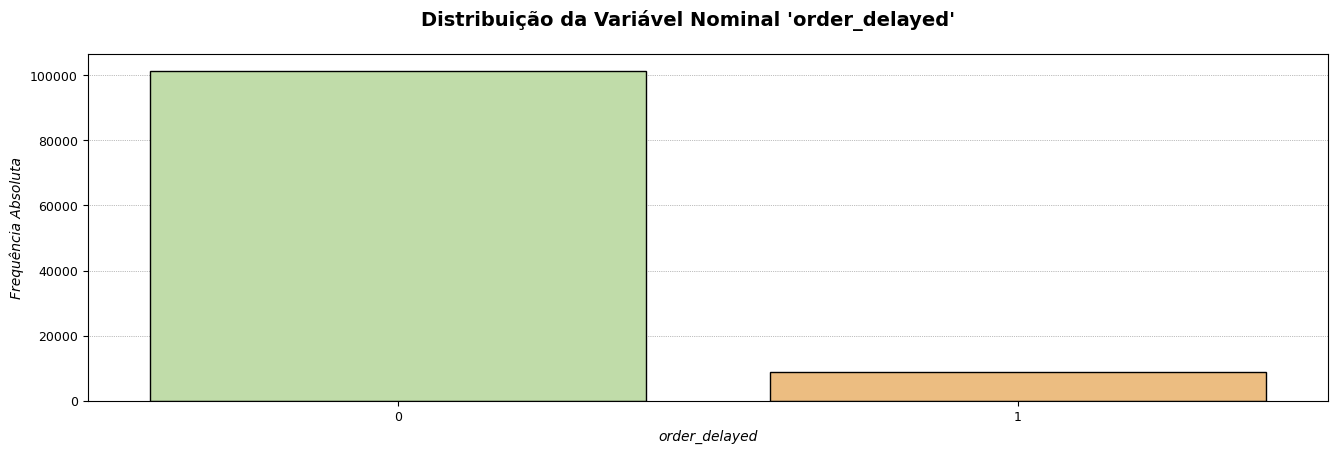

In [14]:
eda.plot_nominal_variable_distribution(response_var)

#### Variáveis Contínuas

In [15]:
eda.descriptive_statistics_continuous_variables(continuous_vars_df)

,Valores Únicos,Desv. Padrão,Variância,Assimetria,Curtose,Normalidade
price,5859,182.305,3.323497e+04,8.031,124.967,Distrib. Não-Normal
freight_value,6924,15.699,2.464470e+02,5.655,60.612,Distrib. Não-Normal
product_weight_g,2171,3741.445,1.399841e+07,3.597,16.254,Distrib. Não-Normal
product_length_cm,100,16.125,2.600260e+02,1.755,3.722,Distrib. Não-Normal
product_height_cm,103,13.410,1.798290e+02,2.255,7.392,Distrib. Não-Normal
product_width_cm,95,11.690,1.366680e+02,1.720,4.668,Distrib. Não-Normal
seller_lat,2162,2.910,8.467000e+00,3.261,21.192,Distrib. Não-Normal
seller_lng,2162,3.241,1.050600e+01,7.107,100.151,Distrib. Não-Normal
customer_lat,14734,5.667,3.211800e+01,1.695,3.656,Distrib. Não-Normal
customer_lng,14735,4.677,2.187700e+01,2.463,24.660,Distrib. Não-Normal


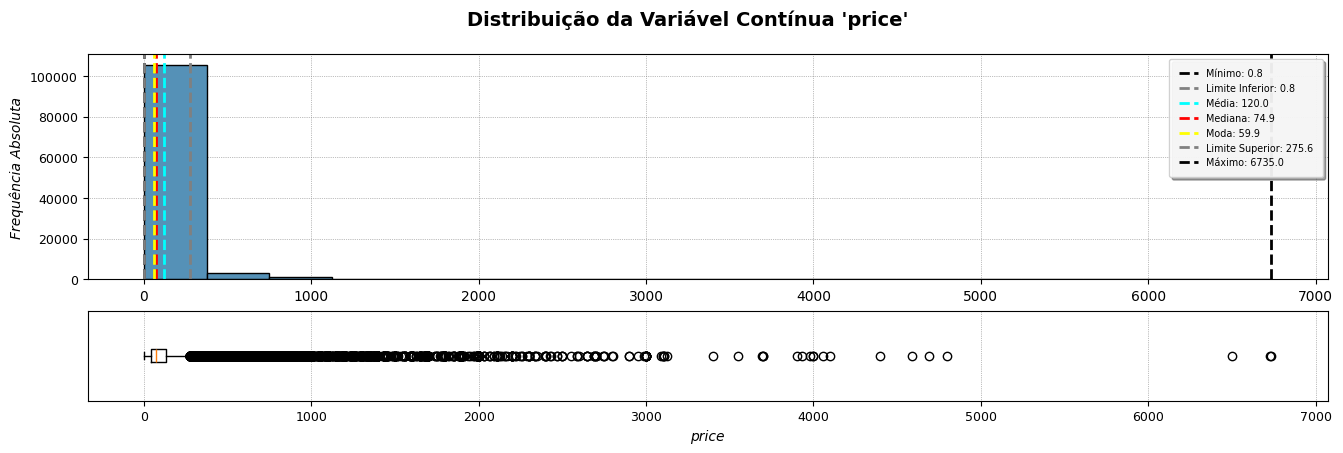

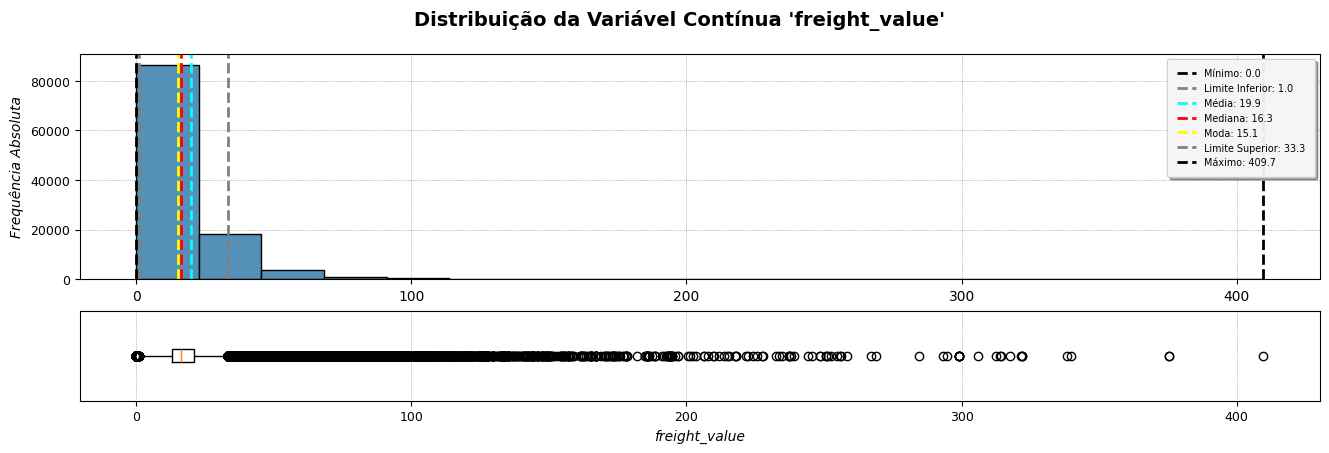

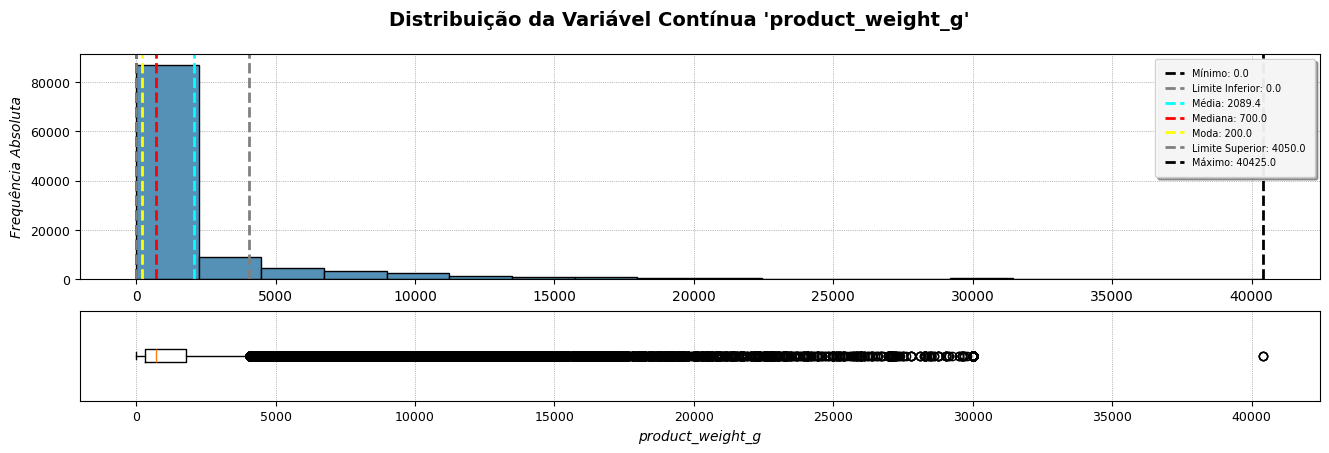

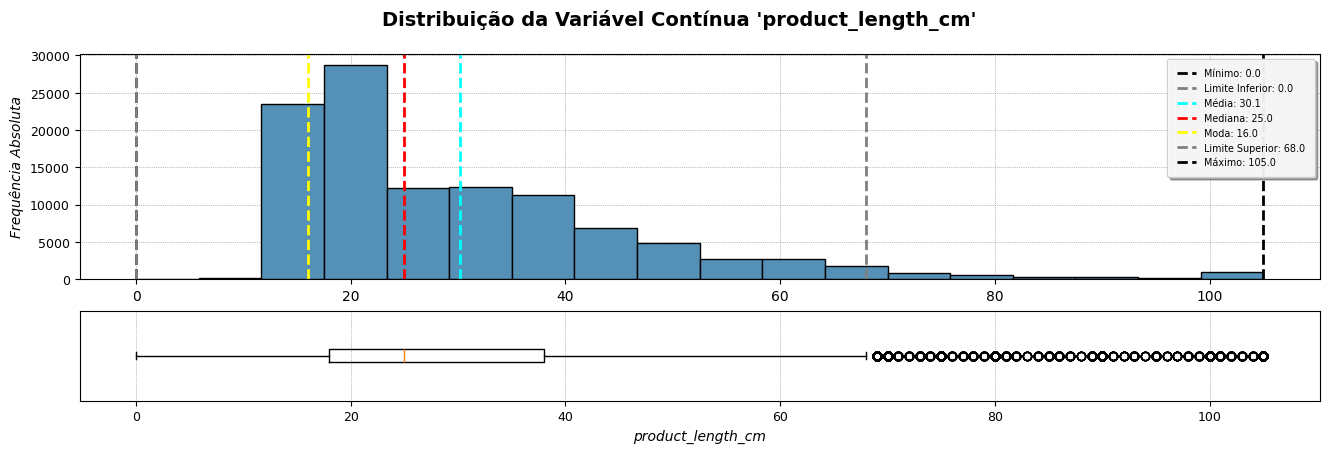

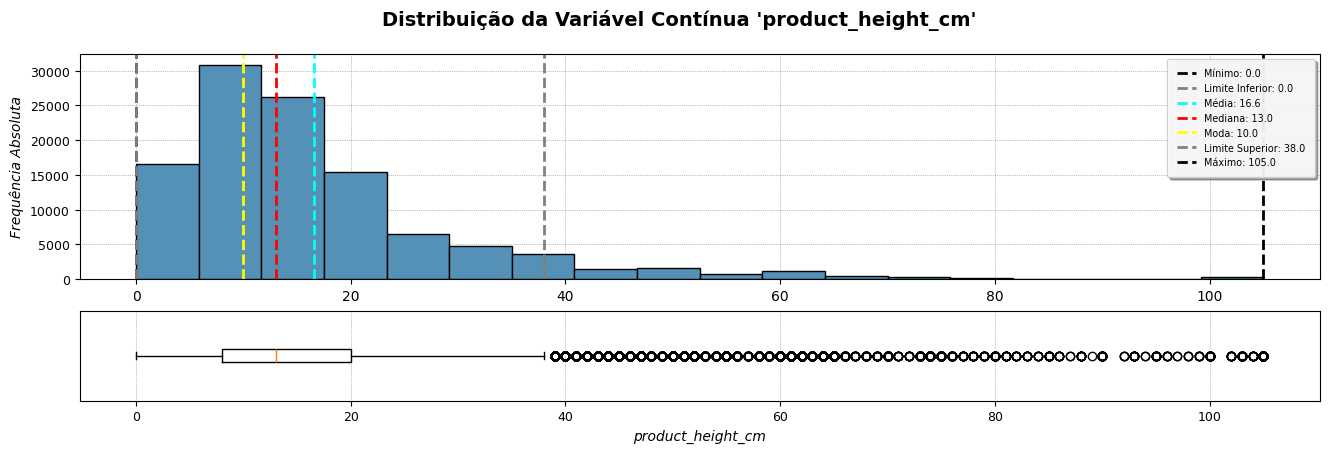

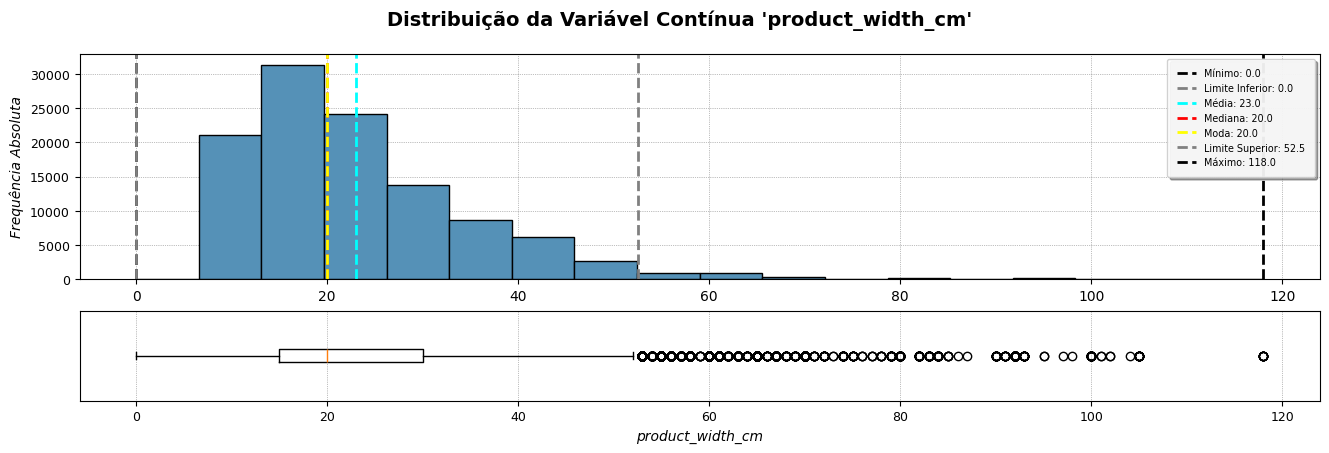

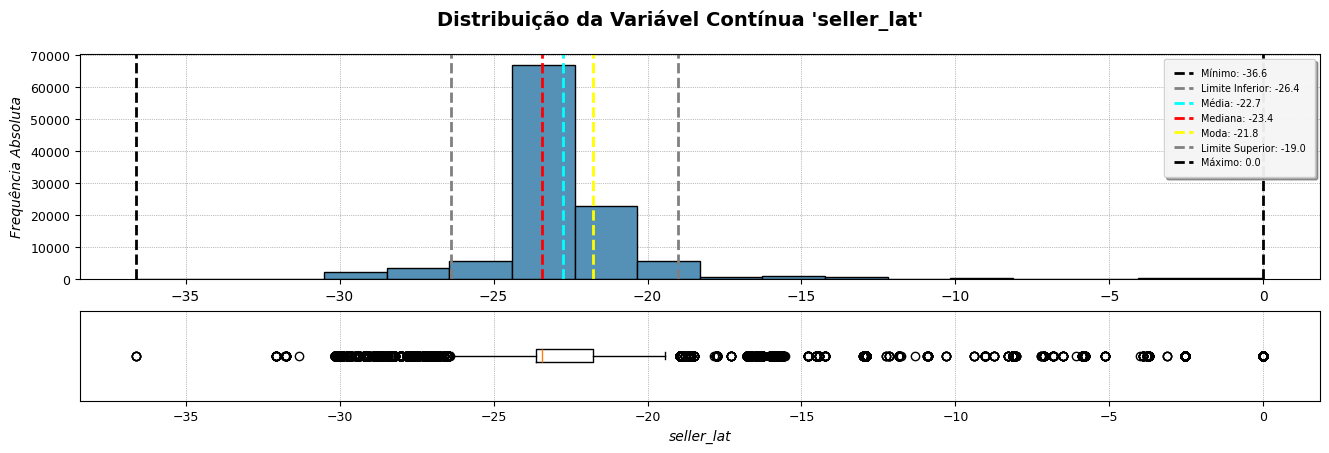

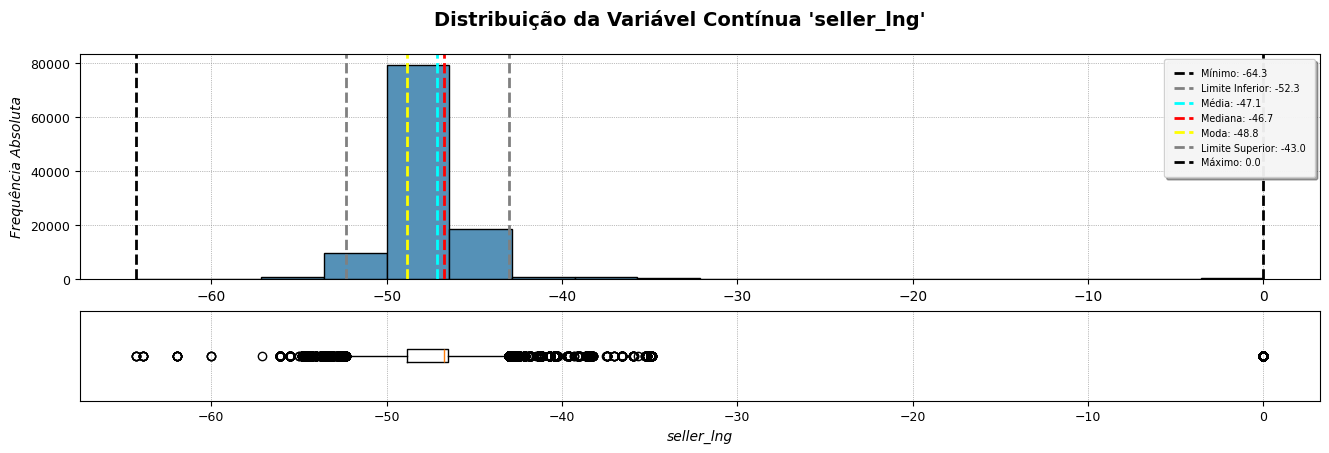

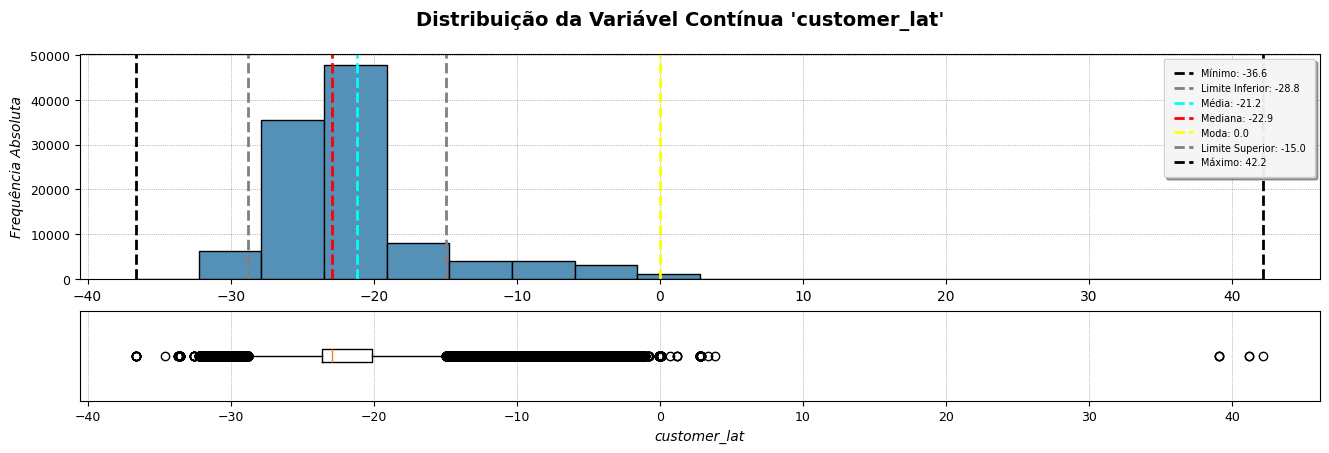

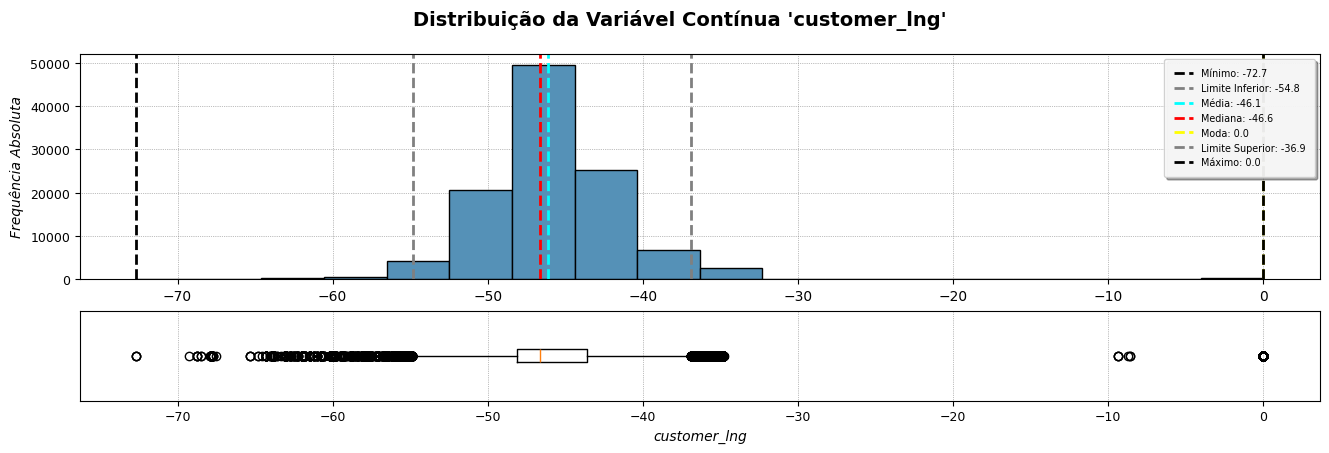

In [16]:
eda.plot_continuous_variables_distributions(continuous_vars_df)

#### Variáveis Discretas

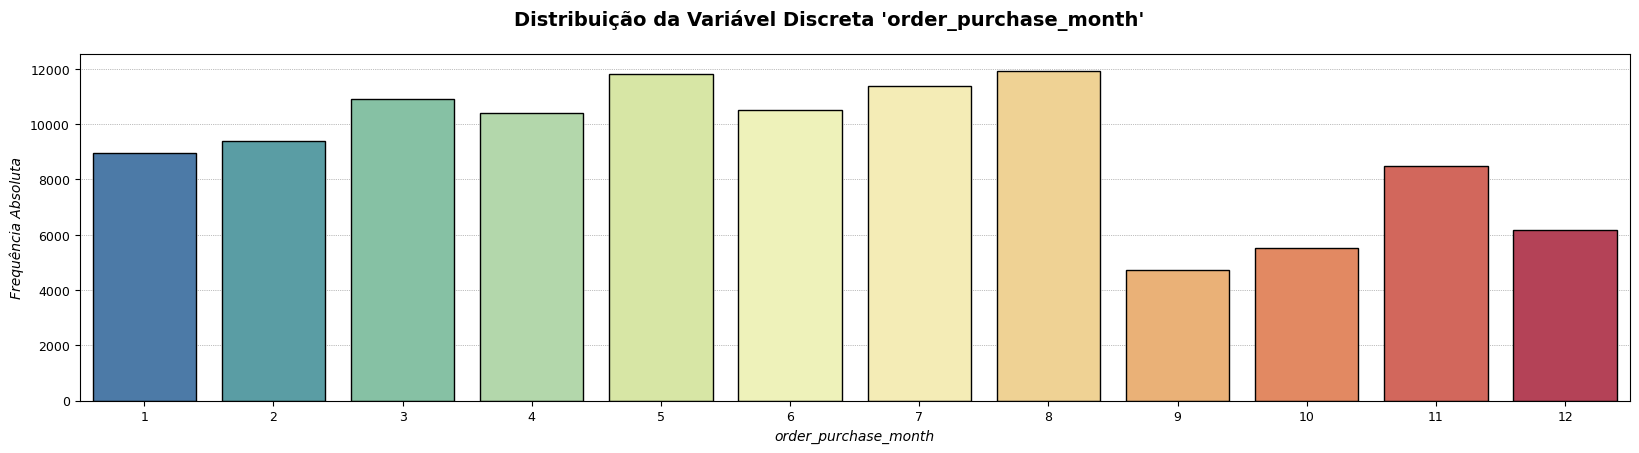

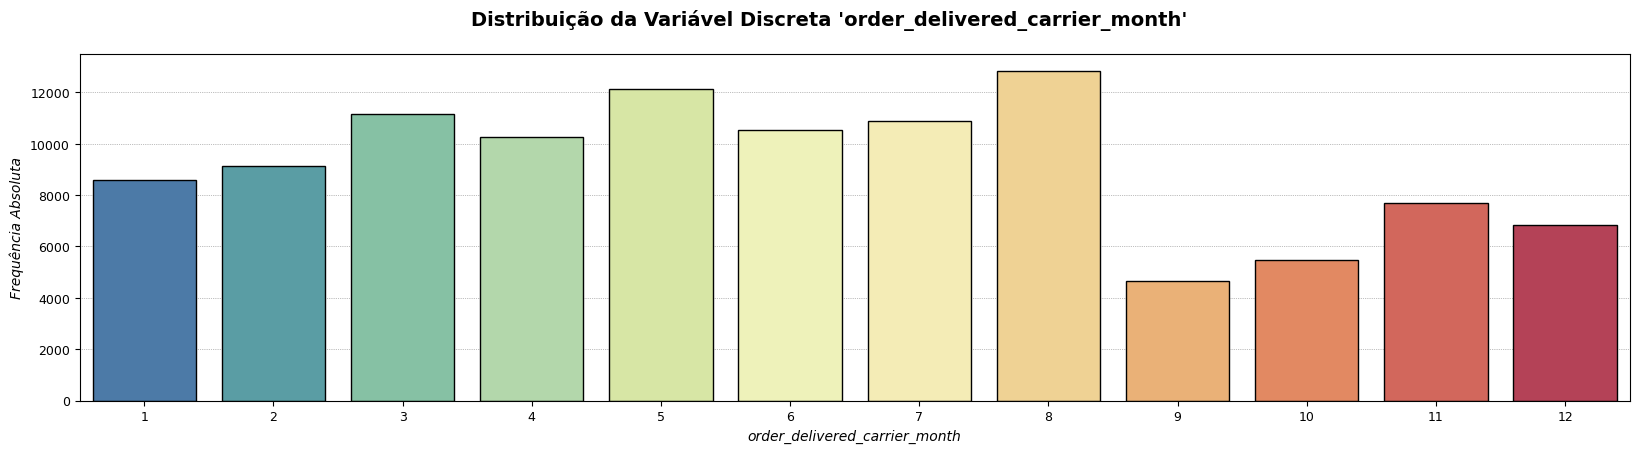

In [17]:
eda.plot_discrete_variables_distributions(discrete_vars_df)

## Modelagem Preditiva

In [18]:
X = df.drop(columns= ['order_delayed']).copy()
y = df['order_delayed'].copy()

### Seleção de Variáveis

In [19]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

for col in X.columns:
    if col in nominal_vars:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Codificar target se necessário
y_labels = LabelEncoder().fit_transform(y)

# Cálculo da mutual information
mi_scores = mutual_info_classif(X, y_labels, discrete_features='auto', random_state=0)

# Organizar os resultados em um DataFrame
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Exibir os melhores atributos
print("Top Variáveis por Mutual Information:\n")
print(mi_series)

Top Variáveis por Mutual Information:

customer_zip_code_prefix         0.024280
customer_lng                     0.023002
customer_lat                     0.021802
seller_state                     0.017947
order_delivered_carrier_month    0.015635
customer_city                    0.015258
order_purchase_month             0.014319
customer_state                   0.011026
seller_zip_code_prefix           0.010341
seller_lat                       0.010283
freight_value                    0.010051
seller_lng                       0.009749
price                            0.006967
seller_city                      0.006573
product_weight_g                 0.002873
product_width_cm                 0.002764
product_category_name            0.001656
product_height_cm                0.001370
product_length_cm                0.000442
dtype: float64


In [20]:
drop_cols = ['product_weight_g', 'product_width_cm', 'product_category_name', 'product_height_cm', 'product_length_cm']

continuos_vars = ['price', 'freight_value', 'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng']

discrete_vars = ["order_purchase_month", "order_delivered_carrier_month"]

nominal_vars = ['seller_zip_code_prefix', 'seller_city', 'seller_state', 
                'customer_zip_code_prefix', 'customer_city', 'customer_state']

X.drop(columns= drop_cols, inplace= True)

### Divisão dos Dados em Conjuntos de Treino e Teste

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 33)

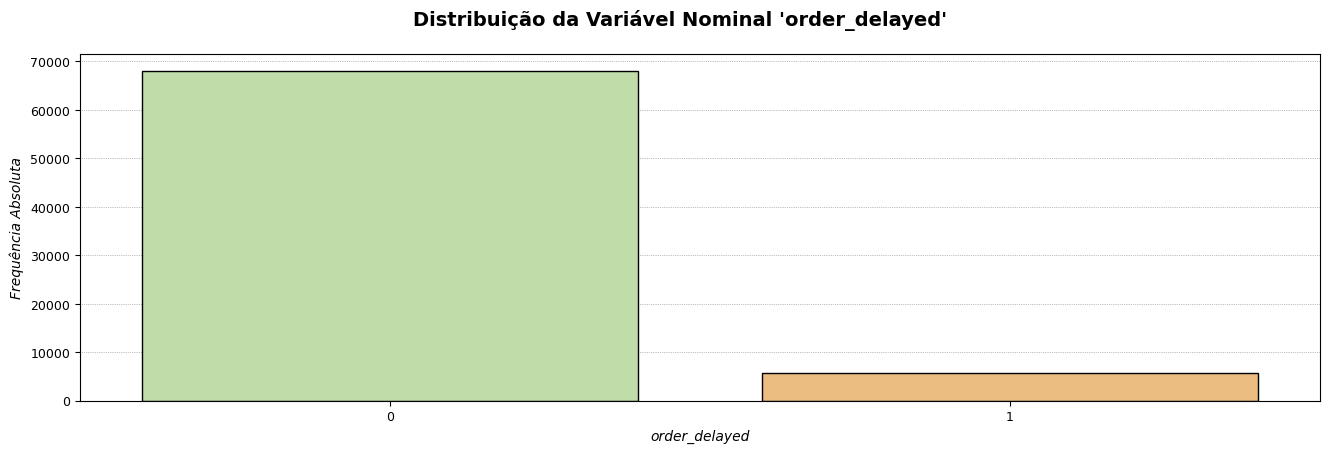

In [22]:
eda.plot_nominal_variable_distribution(y_train)

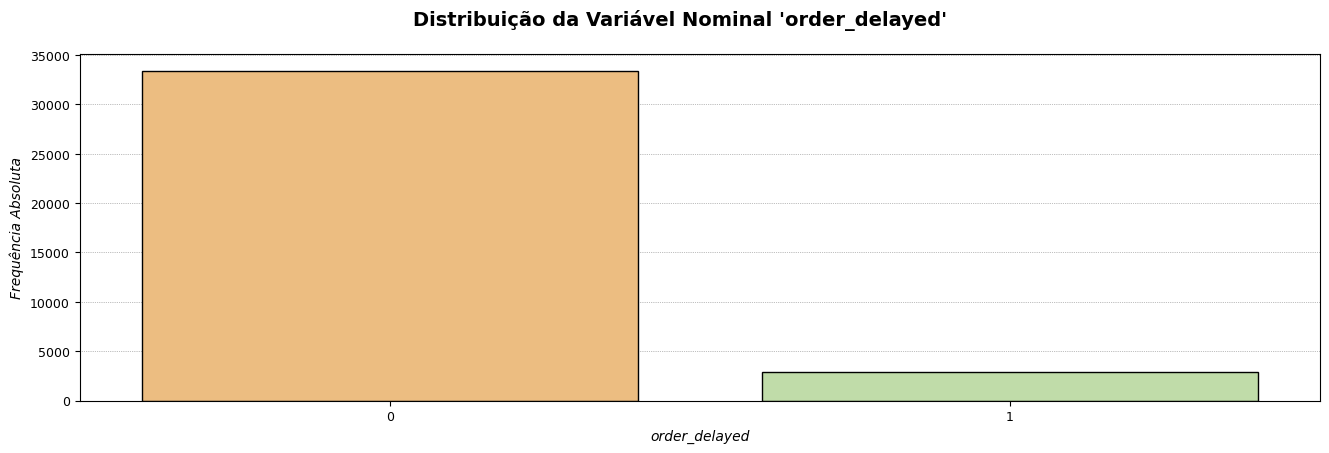

In [23]:
eda.plot_nominal_variable_distribution(y_test)

### Criação do Pipeline de Dados para Modelagem

In [24]:
# Instaciando e criando transformadores para os dados
robust_transformer = RobustScaler()
one_hot_transformer = OneHotEncoder(feature_name_combiner='concat', handle_unknown= 'ignore')

In [25]:
# Criando pré processador de dados para o treinamento dos modelos
preprocessor = ColumnTransformer(
                   transformers= [
                       ('RobustScalingTransformation', robust_transformer, continuos_vars),
                       ('OneHotEncodingTransformation', one_hot_transformer, nominal_vars),
                       ('PassthroughVars', 'passthrough', discrete_vars)])

In [26]:
xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight= 7,
    gamma=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=0.5,
    reg_lambda=1.3,
    scale_pos_weight= 7.3,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=33,
    n_jobs=8
)

In [27]:
# Criando pipeline para transformação de dados e treinamento do modelo XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgb', xgb_model)])

### Treinamento do Modelo XGBoost

In [28]:

from sklearn.model_selection import cross_validate

scoring = {
    "F1": "f1",
    "AUC": "roc_auc", 
    "RECALL": 'recall',
    "PRECISION": 'precision',
    "ACCURACY": 'accuracy'
}

cv_results = cross_validate(
    estimator=xgb_pipeline,
    X=X_train,
    y=y_train,
    cv= 5,
    scoring=scoring,
    return_train_score=True,
    n_jobs= -1
)


In [29]:
print_model_performance(cv_results)

Pontuação de validação (F1): 0.370 ± 0.012
Pontuação de validação (ACCURACY): 0.870 ± 0.001
Pontuação de validação (PRECISION): 0.298 ± 0.007
Pontuação de validação (RECALL): 0.489 ± 0.025
Pontuação de validação (AUC): 0.805 ± 0.006


In [30]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('RobustScalingTransformation',
                                                  RobustScaler(),
                                                  ['price', 'freight_value',
                                                   'seller_lat', 'seller_lng',
                                                   'customer_lat',
                                                   'customer_lng']),
                                                 ('OneHotEncodingTransformation',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['seller_zip_code_prefix',
                                                   'seller_city',
                                                   'seller_state',
                                                   'customer_zip_code_prefix',
                                                   'cus...
                               feature_types=None, feature_weights=None,
                               gamma=1.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=600, n_jobs=8,
                               num_parallel_tree=None, ...))])

### Performance do Modelo com os Dados de Teste

In [31]:
# Avaliação do desempenho
y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]  # Para métricas como AUC

print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

AUC: 0.8066996400591897
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     33420
           1       0.30      0.52      0.38      2943

    accuracy                           0.86     36363
   macro avg       0.62      0.70      0.65     36363
weighted avg       0.90      0.86      0.88     36363



#### Matriz de Confusão

In [32]:
matrix_absolute = confusion_matrix(y_test, y_pred)
matrix_percentage = confusion_matrix(y_test, y_pred, normalize= 'true')

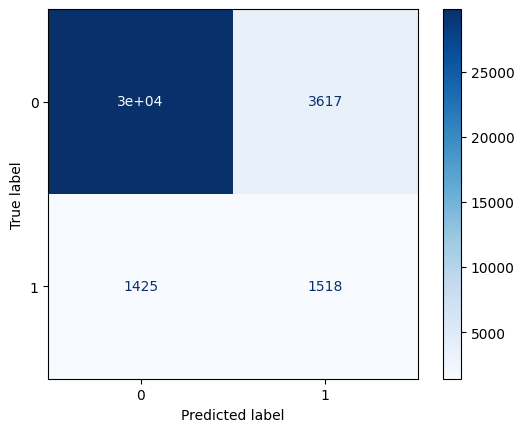

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix= matrix_absolute)
disp.plot(cmap= "Blues");

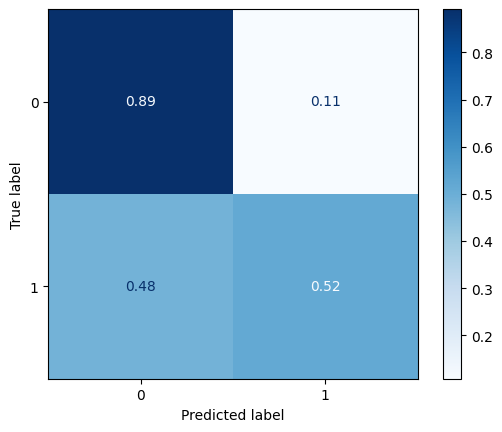

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix= matrix_percentage)
disp.plot(cmap= "Blues");

O modelo criado apresenta um rendimento de 86% na predição de pedidos que sofrerão ou não com atrasos. Dos pedidos atrasados preditos pelo modelo, apenas 30% dos pedidos serão de fato pedidos que irão atrasar, logo, 70% dos valores preditos como que irão atrasar, são alarmes falsos (falsos positivos). Esses mesmos 30% de pedidos preditos corretamente pelo modelo, representam 52% dos pedidos que de fato irão atrasar, logo modelo acerta 52% em relação ao total de vezes que ele deveria ter acertado.

A performance do modelo desta primeira versão não é o ideal, pois o modelo só consegue predizer metade dos pedidos que de fato irão atrasar, e dispara muitos falsos positivos. O grande desbalancemento dos dados influência significativamente a performance do modelo, pois não há dados o suficiente para capturar os padrões de pedidos que serão atrasados. A melhor maneira de aumentar a performance do modelo é capturar mias dados de pedidos atrsados, realizar um trabalho de criação de features que modelem melhor o fenômeno, e recorrer a uma boa análise exploratória para selecionar as features mais adequadas.